**02 - Comparing Gesture Recognizers**

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM, Dropout

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

import time

NUM_POINTS = 50

In [ ]:
"""
x create a test dataset for unistroke gestures based on Wobbrocks logs
    x 10 gestures for each class
- Train an LSTM classifier
- Try to systematically reduce the LSTM's parameter count
    - Create at least 3 different versions
- Compare accuracy and prediction times of the LSTMs and the $1 gesture recognizer
- Report: Which one wouls you choose for a practical application and why?
- [x] (1P) LSTM gesture classifier works.
- [ ] (2P) Systematically compared different parameter counts.
- [ ] (2P) Report
"""

Reading the training data

In [53]:
PATH_TRAIN = "dataset/xml_logs"
PATH_TEST = "dataset/test"

def read_dataset(path:str):
    data = []


    for root, subdirs, files in os.walk(path):
        if 'ipynb_checkpoint' in root:
            continue
        
        if len(files) > 0:
            for f in tqdm(files):
                if '.xml' in f:
                    fname = f.split('.')[0]
                    label = fname[:-2]
                    
                    xml_root = ET.parse(f'{root}/{f}').getroot()
                    
                    points = []
                    for element in xml_root.findall('Point'):
                        x = element.get('X')
                        y = element.get('Y')
                        points.append([x, y])
                        
                    points = np.array(points, dtype=float)
                    
                    scaler = StandardScaler()
                    points = scaler.fit_transform(points)
                    
                    resampled = resample(points, NUM_POINTS)
                    
                    data.append((label, resampled))
    return data

In [ ]:
train = read_dataset(PATH_TRAIN)
test = read_dataset(PATH_TEST)

In [55]:
print("train", len(train))
print("test", len(test))

train 5088
test 160


Prepare the data

In [56]:
train_labels = [sample[0] for sample in train]
test_labels = [sample[0] for sample in test]
labels = [sample[0] for sample in train]

print(set(train_labels))

encoder = LabelEncoder()
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.fit_transform(train_labels)


y_train = to_categorical(train_labels_encoded)
y_test = to_categorical(test_labels_encoded)

train_sequences = [sample[1] for sample in train]
X_train = np.array(train_sequences)

test_sequences = [sample[1] for sample in train]
X_test = np.array(test_sequences)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#"x", sizes: 5088, 'y' sizes: 160

{'right_curly_brace', 'triangle', 'x', 'star', 'caret', 'v', 'rectangle', 'arrow', 'left_sq_bracket', 'pigtail', 'question_mark', 'circle', 'delete_mark', 'right_sq_bracket', 'left_curly_brace', 'check'}
(5088, 50, 2) (5088, 50, 2) (5088, 16) (5088, 16)


In [57]:
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


<div class="alert alert-info"><b>MODEL:</b> LSTM classifier </div>

Try to systematically reduce the LSTM's parameter count (at least **3** versions)

<details open>
<summary> <b> Systematic Approach </b> </summary>

**Default**
- 64 neurons
- accuracy/loss dont get a lot better after Epoch 6
- first dense layer reduces params by over half
- adding a [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) Layer
  - with small amount of rate -> 0.2 

**Dropout**
- does not change the number of params, but slightly better acc + faster
  - not sure if it actually drops anything with 0.2
- use half the amount of neurons and see what happens

**Half**
- 32 neurons
- params down by more than half
- accuracy almost the same (a little worse)
- try another half (i.e. quarter of default) to see if it gets a lot or a little worse

**Quarter**
- 16 neurons
- params pretty low
- accuracy does go down noticably (still very good)
- good strategy probably to stay between *half* and *quarter*
  - acc diff between default and half is pretty negligible
  - acc diff betwen half and quarter not that negligible anymore
- try middle of *half* and *quarter*

**mid-half-quarter**
- 24 neurons
- param count closer to quarter than to half
- accuracy basically in the middle of half and quarter
- so a good compormise

</details>

In [58]:
default_neurons = 64
half_neurons = int(default_neurons / 2)
quarter_neurons = int(default_neurons / 4)
mid_h_q = int( half_neurons - ( quarter_neurons / 2) )

neurons = mid_h_q
neurons

24

In [59]:
# code from "lstm_demo.ipynb"
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# new syntax
model.add(Input((NUM_POINTS, 2)))

model.add(LSTM(neurons))

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance
model.add(Dropout(0.2))

# softmax layer for classification
model.add(Dense(len(set(train_labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [60]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2407 - loss: 2.4588 - val_accuracy: 0.7034 - val_loss: 1.0759 - learning_rate: 0.0010
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6974 - loss: 0.9606 - val_accuracy: 0.9361 - val_loss: 0.3671 - learning_rate: 0.0010
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8857 - loss: 0.4333 - val_accuracy: 0.9686 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 4/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9355 - loss: 0.2549 - val_accuracy: 0.9817 - val_loss: 0.0890 - learning_rate: 0.0010
Epoch 5/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9701 - loss: 0.1482 - val_accuracy: 0.9796 - val_loss: 0.0830 - learning_rate: 0.0010
Epoch 6/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9699 - loss: 0.1275 - val_accuracy: 0.9898 - val_loss: 0.0442 - learning_rate: 0.0010
Epoch 7/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9780 - loss: 0.1009 - 

In [61]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24)             │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,762 (45.95 KB)

 Trainable params: 3,920 (15.31 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,842 (30.64 KB)

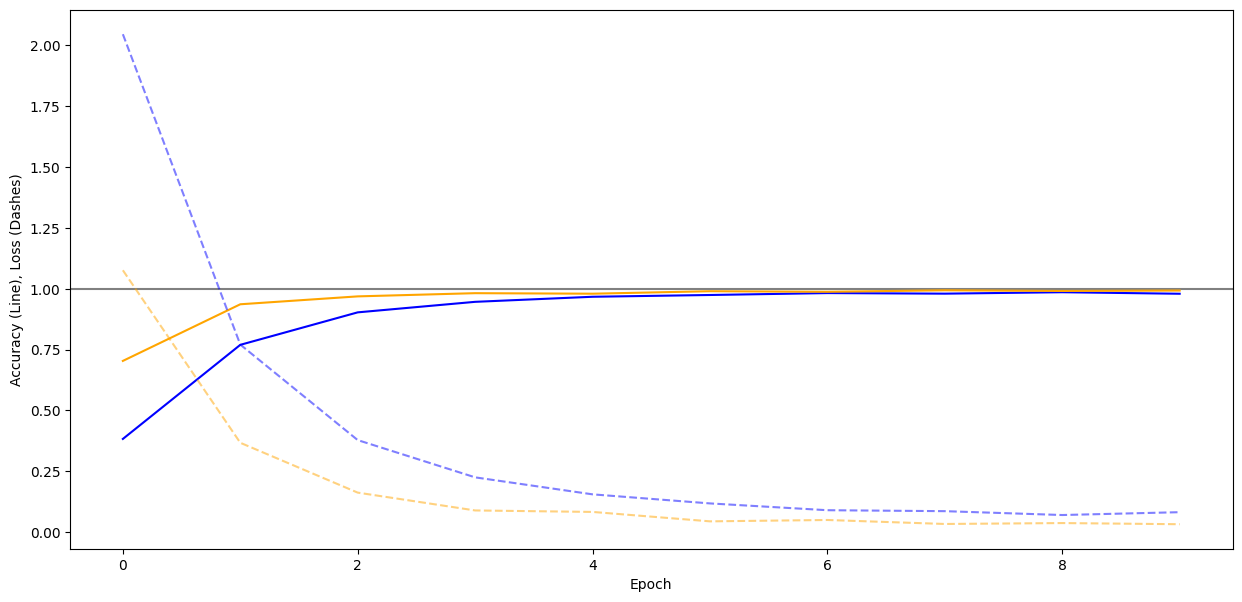

In [62]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
inference time = 0.5447256565093994 sec
0.9925314465408805


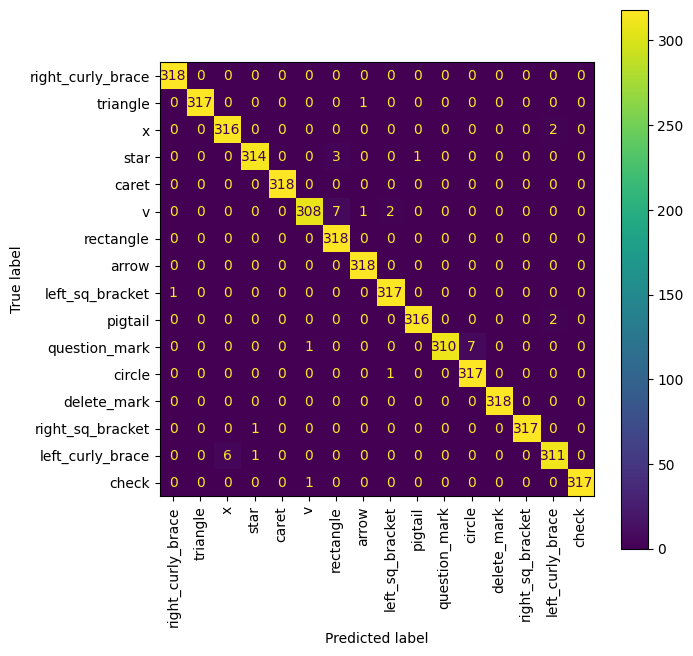

In [63]:
# let the model make predictions for our training data
start = time.time() # measure time
y_predictions = model.predict(X_test)
end = time.time()
inf_time = end - start
print("inference time =", inf_time, "sec") # time in seconds

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

acc_score = accuracy_score(y_test_labels, y_predictions)
print(acc_score)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(7, 7))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

In [64]:
# model.save('gesture-recognizer.keras')

Save logs

In [66]:
import pandas as pd
import json
import os

**!!**

In [143]:
# name = "mid-half-quarter"
# notes_path = "logs/accs.csv"
# history_path = f"logs/{name}-history.json"
# conf_path = f"logs/{name}-conf.json"
# summ_path = "logs/summaries.txt"
# # commented out to avoid accidental overrides

In [144]:
# save general metrics in a table
data = {"model": [name], "accuracy score": [acc_score], 
        "inference time": [inf_time], "trainable params": [model.count_params()],
        "neurons": [neurons]}
# parameter counnt
df = pd.DataFrame(data)
df.to_csv(notes_path, mode="a", header=not os.path.exists(notes_path))

# save the history as a json
with open(history_path, 'w') as f:
    json.dump(history.history, f, indent=4)

# save the confusion matrix as json
with open(conf_path, 'w') as f:
    json.dump(conf_matrix.tolist(), f, indent=4)

# save the summaries (see: https://stackoverflow.com/a/45546663)
with open(summ_path, 'a', encoding="utf-8") as fh:
    fh.write(f"{name}\n")
    model.summary(print_fn=lambda x: fh.write(x + '\n'))

**Comparison**

In [10]:
from recognizer import Recognizer, Parser
rec = Recognizer()

C:\Users\Leonie\AppData\Local\Temp\ipykernel_24888\4208553560.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


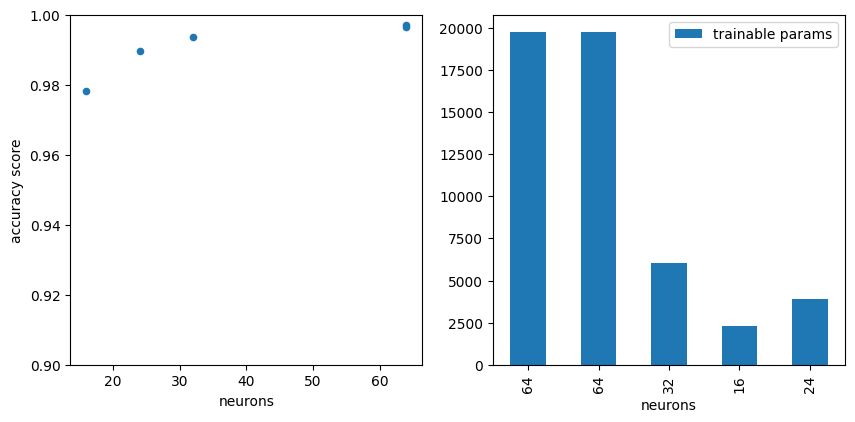

In [133]:
# compare the models by 
df = pd.read_csv("logs/accs.csv")

# labels = pd["model"]
# print(labels)

# read input from accs.csv + plot
# plot acc + num_params (+ inference time)
# df.plot(y="inference time", x="neurons", kind="bar", figsize=(3, 3))
# fig = plt.figure(figsize=(10, 20))
# plt.subplot(1, 2, 1)
# df.plot(x="neurons", y="accuracy score", kind="bar", figsize=(3,3))
# df.plot(x="neurons", y="trainable params", kind="bar", figsize=(3,3))


# df.plot(subplots=[("neurons", "trainable params"), ])
# plt.bar(df["neurons"], df["trainable params"] )

fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
# plt.bar(df["neurons"], df["trainable params"]) ax=plt.gca()
df.plot(x="neurons", y="accuracy score", kind="scatter", ylim=(0.9,1.0) ,ax=plt.gca())
plt.subplot(2, 2, 2)
df.plot(x="neurons", y="trainable params", kind="bar", ax=plt.gca())
fig.show()


In [ ]:
# compare to $1 gesture recognizer on acc and inference time

templates = Parser.parse_xml_files("dataset/templates")
ts = []
y_true = []
predictions = []

for t in templates:
    label, points = t[0]
    ts.append([label, points])

start = time.time() 

for gesture in test:
    label, points = gesture
    result, score = rec.recognize(points, ts)
    predictions.append(result)
    y_true.append(label)

end = time.time()
d_inf_time = end - start


In [137]:
d_acc_score = accuracy_score(y_true, predictions)

print(len(y_true), y_true)
print(len(predictions), predictions)
print("inf time:", d_inf_time)
print("accuracy_score:", d_acc_score )

160 ['arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'arrow', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'caret', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'check', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'circle', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'delete_mark', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_curly_brace', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'left_sq_bracket', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail', 'pigtail

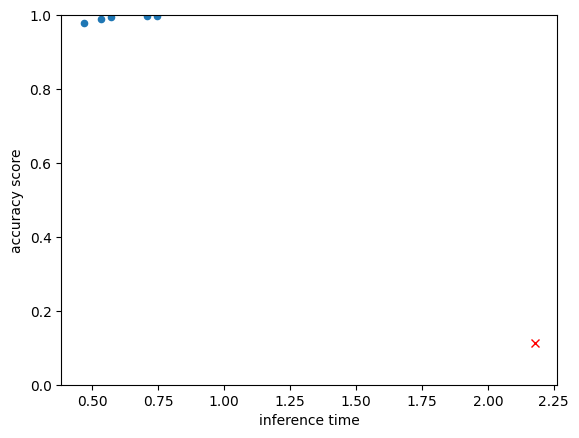

In [140]:
p = df.plot(x="inference time", y="accuracy score", kind="scatter", ylim=(0,1.0) ,ax=plt.gca())
p.plot(d_inf_time, d_acc_score, "xr")

# Report

**LSTM**
- fast if a dataset exists and pc is okay
  - collecting dataset can be a hassle (for this it's probably okay)
- finding the right parameter count is fine
- good if model works quickly (Don't really know how to debug a network)
- model is pretty fast and reliable
- very obscured

**$1**
- if the alogrithm works it's pretty reliable (and quick enough)
- feels smart, like you actually contributed something
- no data collection!!

**Choice**
- Probably depends on the application and the setting
- Model:
  - If the dataset exists + model seems easy enough to set up (like right now)
  - If you need something very robust, that you know a model will be able to do
- Algorithm:
  - If no data exists, I would probably try an algorithm first
    - loss setup involved
    - you can see if/how it works while your working on it (don't need to collect data and then realize that the model you made is bad)
  - If the application only requires easy/small-scale recognition